In [1]:
import numpy as np

import tensorflow as tf

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers

tf.keras.backend.clear_session()

/Users/sunho/anaconda3/envs/dataserver/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sunho/anaconda3/envs/dataserver/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sunho/anaconda3/envs/dataserver/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sunho/anaconda3/envs/datase

In [2]:
import gensim
vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

In [7]:
from metaflow import Flow
flow = Flow('PrepareFeatures').latest_successful_run
raw_df = flow.data.clean_series_features

In [47]:
from metaflow import Flow
flow = Flow('PredictVocab').latest_successful_run
u_df = flow.data.unknown_words_df
n_df = flow.data.known_words_df


In [49]:
import qgrid
qgrid.show_grid(u_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [4]:
nouse_vec = 2
estimators = 100
k = 30
perplexity = 13
n_iter = 300

In [8]:
raw_df

,userId,word,time,count,signal,wpm,signal0,diff0,signal1,diff1,pos
295843,mzQZO80m21TM0C7gRcqb,one,72432,1,1.0,203.866106,1.0,0.595810,1.0,0.242523,NN
294913,jum2juGs6bL7zqv8vAjQ,deep,172595,1,1.0,103.686636,0.0,0.987187,1.0,1.010440,JJ
223813,OQJ8K3jcLOM3eYaImkyN,jonas,82670,1,1.0,58.542879,1.0,0.477882,1.0,0.478947,NNS
223869,OQJ8K3jcLOM3eYaImkyN,one,82633,1,1.0,108.546039,1.0,0.477454,1.0,0.478947,CD
223876,OQJ8K3jcLOM3eYaImkyN,always,82633,1,1.0,110.406504,1.0,0.477523,1.0,0.478877,RB
...,...,...,...,...,...,...,...,...,...,...,...
171870,8ACCQYz8NMc4Lc9Nze3R,since,2210712,25,1.0,156.926279,1.0,0.506551,1.0,0.150278,IN
171865,8ACCQYz8NMc4Lc9Nze3R,till,2012945,4,1.0,156.979978,1.0,0.711782,1.0,0.708056,IN
171860,8ACCQYz8NMc4Lc9Nze3R,make,2012243,28,1.0,149.288441,1.0,0.520127,1.0,0.162882,VB
171966,8ACCQYz8NMc4Lc9Nze3R,aside,2010994,17,1.0,112.250611,1.0,0.685752,1.0,1.432373,RB


In [9]:
import xgboost as xgb
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift, KMeans, estimate_bandwidth

words = raw_df['word'].unique()
vector_list = [vec_model[word] for word in words if word in vec_model.vocab]
words_filtered = [word for word in words if word in vec_model.vocab]
word_vec_zip = zip(words_filtered, vector_list)
word_vec_dict = dict(word_vec_zip)
df2 = pd.DataFrame.from_dict(word_vec_dict, orient='index')
# .set_index('word').join(df2, how='right').reset_index().rename(columns={'index': 'word'})

df = raw_df.copy().set_index('word')\
    .join(df2[[]], how='right').reset_index().rename(columns={'index': 'word'})
df3 = raw_df[['word']].copy().set_index('word')\
    .join(df2, how='right').reset_index(drop=True)
kmeans = KMeans(n_clusters=5).fit(df3)
df = df.join(pd.get_dummies(kmeans.predict(df3)))
df = df.join(pd.get_dummies(df['pos']))
df = df.loc[df['userId'] == '8ACCQYz8NMc4Lc9Nze3R']
del df['userId']
import pyphen

dic = pyphen.Pyphen(lang='en_US')

data_df = df
data_df['len'] = data_df['word'].map(lambda x: len(str(x)))
data_df['syl'] = data_df['word'].map(lambda x: len(dic.inserted(str(x)).split('-')))
data_df = data_df.iloc[:, (df.columns != 'word') & (df.columns != 'pos')]
y = 1 - data_df['signal']
x = data_df.iloc[:, data_df.columns != 'signal']
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 40)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [10]:
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [11]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.transform(x_test)


In [13]:
SEED = 2
NFOLDS = 5

In [14]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 300,
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 300,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 300,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 100,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [15]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [16]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(n_splits = NFOLDS, random_state = SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_


/Users/sunho/anaconda3/envs/dataserver/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



In [17]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [18]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

In [19]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

In [20]:
cols = x.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': [str(col) for col in cols],
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })


In [21]:
def plot_features(text):
    trace = go.Scatter(
        y = feature_dataframe[text].values,
        x = feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
            color = feature_dataframe[text].values,
            colorscale='Portland',
            showscale=True
        ),
        text = feature_dataframe['features'].values
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= text,
        hovermode= 'closest',
        xaxis={'type': 'category'},
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')
plot_features('Random Forest feature importances')
plot_features('Extra Trees  feature importances')
plot_features('AdaBoost feature importances')
plot_features('Gradient Boost feature importances')

In [22]:
x_train2 = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train,svc_oof_train), axis=1)
x_test2 = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [23]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators= 1500,
 max_depth= 8,
 min_child_weight= 1,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train2, y_train)
predictions = gbm.predict_proba(x_test2)

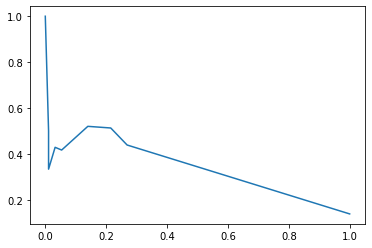

In [24]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
precision, recall ,_ = precision_recall_curve(y_test, predictions[:, 1])
plt.plot(recall, precision)

In [562]:

wrong_df = pd.DataFrame(x_test[(y_test - (predictions[:, 1] > 0.5)) == -1])

wrong_df.columns = x.columns.values
wrong_df

,words,time,count,wpm,signal0,diff0,signal1,diff1,0,1,...,UH,VB,VBD,VBG,VBN,VBP,VBZ,WRB,len,syl
0,0.034368,0.748043,0.005348,0.143211,1.0,0.006307,0.0,0.618698,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.357143,0.0
1,1.000000,0.571836,0.002674,0.103603,1.0,0.159833,0.0,0.468039,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.4
2,0.077963,0.727748,0.002674,0.104242,1.0,0.159326,0.0,0.597560,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.714286,0.8
3,1.000000,0.498583,0.000000,0.095003,0.0,0.111386,0.0,0.432010,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0
4,1.000000,0.455118,0.000000,0.067741,0.0,0.041617,0.0,0.443772,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.571429,0.6
5,0.102784,0.793652,0.000000,0.046588,1.0,0.039311,0.0,0.801219,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.571429,0.4
6,1.000000,0.709561,0.000000,0.071933,0.0,0.260620,1.0,0.530789,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.357143,0.0
7,1.000000,0.455891,0.000000,0.120935,0.0,0.203978,0.0,0.310980,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.285714,0.2
8,1.000000,0.157364,0.000000,0.148599,0.0,0.197485,0.0,0.002792,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.428571,0.0
9,1.000000,0.549743,0.000000,0.121190,0.0,0.049057,1.0,0.537031,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.428571,0.0


In [121]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

In [1125]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV

cv = xgb.XGBClassifier(n_estimators=30, max_depth = 7)
tuned_parameters = {
    'n_estimators': [100],
    'max_depth': [3,5,7],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.5, 0.6, 0.8],
    'colsample_bytree': [0.5, 0.6, 0.8],
    'min_child_weight': [0.5,1,1.5,2,10],
    'eta': [0.2]
}
clf = GridSearchCV( xgb.XGBClassifier(),
    tuned_parameters,
    scoring = 'f1'
)

clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.transform(x_test.to_numpy())
# x_scaled = min_max_scaler.fit_transform(x_train.to_numpy())
# scores = cross_validate(cv, x_train, y_train, cv=10, scoring={'p': 'precision', 'r': 'recall'})
# (scores['test_p'].mean(), scores['test_r'].mean())

Best parameters set found on development set:

{'colsample_bytree': 0.6, 'eta': 0.2, 'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.6}
0.478 (+/-0.048) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 100, 'subsample': 0.5}
0.482 (+/-0.038) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 100, 'subsample': 0.6}
0.480 (+/-0.052) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 0.5, 'n_estimators': 100, 'subsample': 0.8}
0.473 (+/-0.027) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}
0.478 (+/-0.043) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
0.474 (+/-0.045) for {'colsample_bytree': 0.5, 'eta': 0.2, 'gamma': 0, '

In [1083]:
x_test_scaled = min_max_scaler.transform(x_test.to_numpy())
pred = cv.predict_proba(x_test_scaled)[:, 1]

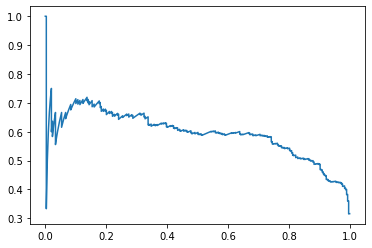

In [1084]:
precision, recall ,_ = precision_recall_curve(y_test, pred)
plt.plot(recall, precision)

In [1094]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
import matplotlib.pyplot as plt

 y_test.to_numpy()

disp = plot_precision_recall_curve(cv, x_test_scaled, y_test.to_numpy())


IndentationError: unexpected indent (<ipython-input-1094-de117f241c65>, line 6)

In [877]:

x_test_scaled = min_max_scaler.transform(x_test.to_numpy())

metrics.plot_roc_curve(cv, x_test_scaled, y_test)

ValueError: KerasClassifier should be a binary classifier

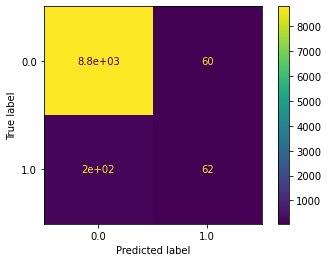

In [718]:
test_pred = model2.predict(x_test)

import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model2, x_test, y_test)